In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from time import sleep
from hydro_serving_grpc.reqstore import reqstore_client

import hydro_serving_grpc as hs_grpc
from client import HydroServingClient, HydroServingServable, HydroServingModel

In [2]:
hs_client = HydroServingClient("localhost:9090")

In [3]:
adult_model = hs_client.get_model("adult-tensor", 1)

In [9]:
df = pd.read_csv("hs_demos/data/test_adult.csv")
df.head()

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,23,4,4,1,2,3,4,1,2,2,30,9
1,46,4,3,0,2,0,2,1,2,2,45,9
2,42,4,4,0,2,0,4,1,2,2,50,9
3,36,7,4,0,8,0,4,1,2,2,40,9
4,61,4,3,2,2,4,4,0,2,2,40,9


Plot random sample

In [10]:
x = df.iloc[np.random.randint(0, df.shape[0])]
print(x)

Age               55
Workclass          4
Education          3
Marital Status     0
Occupation         2
Relationship       0
Race               4
Sex                1
Capital Gain       0
Capital Loss       2
Hours per week    40
Country            9
Name: 718, dtype: int64


Send data to reqstore

In [26]:
adult_servable = hs_client.deploy_servable("adult-tensor", 1)
for _ in tqdm(range(10)):
    sleep(0.2)
    i = np.random.randint(0, df.shape[0])
    x = np.array(df.iloc[i])[np.newaxis]
    result = adult_servable(x, _profile=True)
adult_servable.delete()
print("Example result: ", result)

2019-08-07 17:24:59.189 | INFO     | client:deploy_servable:76 - adult-tensor-1-dark-haze is ServableStatus.STARTING
2019-08-07 17:25:02.092 | INFO     | client:deploy_servable:76 - adult-tensor-1-dark-haze is ServableStatus.SERVING



Example result:  {'prediction': array([[1]])}


Check that data is in the reqstore

In [6]:
rs_client = reqstore_client.ReqstoreClient("localhost:9090", insecure=True)
subsample = list(rs_client.subsampling(str(adult_model.id), 10))
x = adult_model.contract.decode_request(subsample[0].entries[0].request)
x

{'input': array([[42,  4,  4,  0,  5,  0,  4,  1,  0,  2, 50,  9]])}

In [9]:
x['input'][0]

array([42,  4,  4,  0,  5,  0,  4,  1,  0,  2, 50,  9])

In [30]:
# new_d = dict([(k, v.ravel()) for k, v in x.items()])
x_df = pd.DataFrame.from_dict(x['input'])
x_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,42,6,1,0,6,0,4,1,2,2,60,9


In [44]:
def get_dataframe_subsample(model, subsample_size=1000):
    # Get subsample to work with
    model_id = model.id
    rs_entries = []
    for r in rs_client.subsampling(str(model_id), amount=subsample_size):
        rs_entries.extend(r.entries)

    requests = [model.contract.decode_request(e.request)['input'] for e in rs_entries]
    rs = []
    feature_order = model.contract.input_names
    data = np.vstack(requests)
    df = pd.DataFrame(data)
    df.drop_duplicates(inplace=True)
    return df

In [45]:
get_dataframe_subsample(adult_model, 10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,24,4,1,1,7,1,4,1,2,2,40,9
1,46,4,4,1,2,1,4,1,2,2,40,9
3,40,4,0,0,5,0,4,1,2,2,40,9
5,42,6,1,0,6,0,4,1,2,2,60,9
6,39,4,4,2,6,1,4,0,2,2,40,9
7,43,4,4,0,6,0,4,1,2,2,45,9


Fetch reqstore descriptors about this image

In [9]:
folder = adult_model.id
ts = subsample[0].ts
uid = subsample[0].entries[0].uid

Check reqstore again

In [10]:
r = rs_client.get(str(folder), ts, uid)
r

TsRecord(ts=1565181220202, entries=[Entry(uid=7)])

Send a lot of data to reqstore

In [15]:
adult_servable = hs_client.deploy_servable("adult-columnar", 1)
for i in tqdm(range(df.shape[0]//100 - 1)):
    sleep(0.2)
    x = df.iloc[i*100:(i+1)*100]
    adult_servable(x, _profile=True)
adult_servable.delete()

2019-08-07 15:35:57.166 | INFO     | client:deploy_servable:76 - adult-columnar-1-wandering-night is ServableStatus.STARTING
2019-08-07 15:36:00.255 | INFO     | client:deploy_servable:76 - adult-columnar-1-wandering-night is ServableStatus.SERVING


In [16]:
def get_dataframe_subsample(model, subsample_size):
    model_id = model.id
    rs_entries = []
    for r in rs_client.subsampling(str(model_id), amount=subsample_size):
        rs_entries.extend(r.entries)

    requests = [model.contract.decode_request(e.request) for e in rs_entries]

    # concat requests into dataframe format
    rs = []
    feature_order = model.contract.input_names
    for r in requests:
        column_arrays = []
        for feature_name in feature_order:
            column_arrays.append(r[feature_name])
        df = pd.DataFrame(np.hstack(column_arrays), columns=feature_order)
        rs.append(df)
    reqstore_data = pd.concat(rs)

    # Sort columns according to feature names order
    reqstore_data = reqstore_data.loc[:, model.contract.input_names]
    reqstore_data.drop_duplicates(inplace=True)
    return reqstore_data

In [17]:
subsample_df = get_dataframe_subsample(adult_model, 10000)
subsample_df.head()

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,43,4,4,0,6,0,4,1,2,2,40,9
0,31,4,3,1,2,1,4,1,2,2,45,5
1,61,4,4,2,1,1,4,0,2,2,40,1
2,27,4,4,1,2,3,2,0,2,2,40,9
3,39,7,4,2,1,4,4,0,2,2,40,9


In [18]:
"Length of subsample is ", subsample_df.drop_duplicates().shape[0]

('Length of subsample is ', 7049)

Send model description and exlained instance description to rootcause

In [19]:
r = requests.post("http://localhost/rootcause/anchor", json={"model":{"name":"adult-columnar", "version":1},
                                                      "explained_instance":{"timestamp":ts, "uid": uid}})


In [20]:
r.text

'{}\n'

In [21]:
redirect_url = r.headers['Location']
print(redirect_url)
requests.get(redirect_url).text

http://localhost/rootcause/status/anchor/457d3b46-9f20-41a6-bb9b-c0c3b035dcde


'{\n  "state": "PENDING"\n}\n'

In [279]:
requests.get(redirect_url).text

'<html>\r\n<head><title>504 Gateway Time-out</title></head>\r\n<body>\r\n<center><h1>504 Gateway Time-out</h1></center>\r\n<hr><center>nginx/1.15.12</center>\r\n</body>\r\n</html>\r\n'

In [79]:
import json
import ast

result_id = requests.get(redirect_url).json()['result']
result = requests.get(f"http://localhost/rootcause/fetch_result/rise/{result_id}")
result_response = result.json()
result_response

{'completed_at': 'Tue, 30 Jul 2019 12:13:53 GMT',
 'created_at': 'Tue, 30 Jul 2019 12:13:44 GMT',
 'explained_instance': {'timestamp': 1564488796200, 'uid': 18},
 'model': {'name': 'mnist', 'version': 1},
 'result': {'masks': '[[[7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 7, 7], [7, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7

In [80]:
masks = np.array(ast.literal_eval(result_response['result']['masks']))

Masks is an array of shape (number of classes, width, heigh). It can be seen as a collection of masks of shape (width, height), one for each class, which show which parts of images activate that particular class.

In [81]:
masks.shape 

(10, 28, 28)

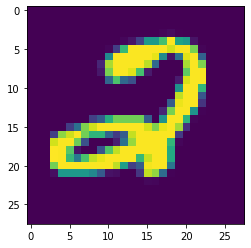

In [94]:
request = rs_client.get(str(folder), ts, uid).entries[0].request
x = mnist_model.contract.decode_request(request)['input']
# Original image from reqstore
plt.imshow(x[0])

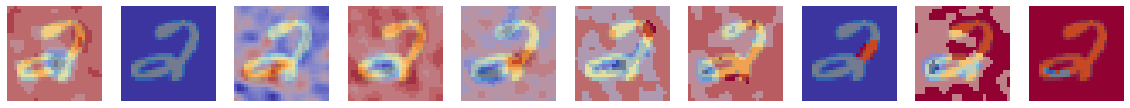

In [116]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(20, 5)
for i in range(10):
    axes[i].imshow(x[0])
    axes[i].imshow(masks[i]/255., alpha = 0.7, cmap = "coolwarm")
    axes[i].axis("off")

In [74]:
# from keras.applications import DenseNet201
from keras.applications.densenet import decode_predictions, DenseNet201


In [ ]:
input_shape = (224, 224, 3)

In [55]:
dnet = DenseNet201(weights="hs_demos/densenet/densenet201_weights_tf_dim_ordering_tf_kernels.h5")

In [57]:
from PIL import Image

In [88]:
width, height

(800, 532)

In [105]:
def thumbnail(img, size=224):

    from math import floor
    from PIL import Image

    img = img.copy()

    if img.mode not in ('L', 'RGB'):
        img = img.convert('RGB')

    width, height = img.size

    if width == height:
        img.thumbnail((size, size), Image.ANTIALIAS)

    elif height < width:
        ratio = float(width) / float(height)
        newwidth = ratio * size
        img = img.resize((int(floor(newwidth)), size), Image.ANTIALIAS)

    elif width < height:
        ratio = float(height) / float(width)
        newheight = ratio * size
        img = img.resize((size, int(floor(newheight))), Image.ANTIALIAS)

    return img



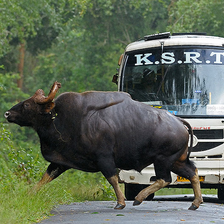

In [113]:
img = Image.open("hs_demos/densenet/demo_image.jpg")
new_width = 224
new_height = 224

img = thumbnail(img)
width, height = img.size

left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
img = img.crop((left, top, right, bottom))
img

In [114]:
img = np.array(img)[np.newaxis]
img.shape


(1, 224, 224, 3)

In [115]:
from grpc import ssl_channel_credentials
hs_client = HydroServingClient("dev.k8s.hydrosphere.io", credentials=ssl_channel_credentials())

In [127]:
densenet = hs_client.get_model("densenet201")

In [128]:
densnet_servable = hs_client.deploy_servable("densnet201")
densnet_servable(img)

_Rendezvous: <_Rendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = ""
	debug_error_string = "{"created":"@1565174737.317357000","description":"Error received from peer ipv4:18.184.72.114:443","file":"src/core/lib/surface/call.cc","file_line":1052,"grpc_message":"","grpc_status":2}"
>

In [111]:
probas = dnet.predict(np.array(img)[np.newaxis])

In [112]:
decode_predictions(probas)

[[('n03891251', 'park_bench', 0.85097337),
  ('n04485082', 'tripod', 0.13217789),
  ('n02793495', 'barn', 0.0155348955),
  ('n03028079', 'church', 0.0013080938),
  ('n04228054', 'ski', 2.7814372e-06)]]